# RNN

#### Import stuff

In [1]:
import numpy as np
from scipy.special import softmax
from math import tanh, sin, pi
import matplotlib.pyplot as plt

#### Create $\textrm{sin}()$ dataset

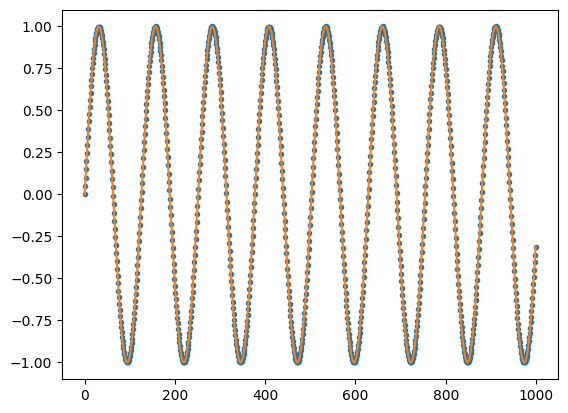

In [2]:
#PARAMETERS:
data_0 = 0
data_m = 10 * pi
data_points = 1000
def f_sin(x):
    return sin(x/20)
x_sin = np.empty(0)
y_sin = np.empty(0)
for i in range(data_points):
    point = i #* (data_m - data_0)/data_points
    x_sin = np.append(x_sin, point)
    y_sin = np.append(y_sin, f_sin(point))
plt.plot(x_sin, y_sin,'.')
plt.plot(x_sin, y_sin)

### Cell structure

<img src="description-block-rnn-ltr.png" alt="rnn" width="750"/>

$g_1$ is $\textrm{tanh}()$ function

$g_2$ is $\textrm{softmax}()$ function

Comparing to the DL book, the adopted notation corresponds as follows: (image | this code | book)

$W_{aa} = W_{hh} = W$ (hidden-hidden)

$W_{ax} = W_{ih} = U$ (input-hidden)

$W_{ya} = W_{ho} = V$ (hidden-output)

In [3]:
class RNN:
    def __init__(self, io_dim=1, h_dim=10, cells=10):
        self.io_dim = io_dim
        self.h_dim = h_dim
        self.cells = cells

        self.Wih = np.random.uniform(0, 0.99, (h_dim, io_dim))
        self.Who = np.random.uniform(0, 0.99, (io_dim, h_dim))
        self.Whh = np.random.uniform(0, 0.99, (h_dim, h_dim))

    def forward(self, X):
        h = np.zeros((self.cells + 1, self.h_dim, self.io_dim)) #Last h is h0
        if self.h_dim == 1:
            h = h.reshape(self.cells)

        y = np.zeros((self.cells, self.io_dim))
        if self.io_dim == 1:
            y = y.reshape(self.cells)

        for cell in range(1,self.cells+1): #h0 is zeros
            h[cell] = np.tanh(self.Whh.dot(h[cell-1]) + self.Wih.dot(X[cell-1]))
            y[cell-1] = self.Who.dot(h[cell])
        return h, y

    def backward(self, X_train, Y_train, truncation_val=10):
        #dLdWho = np.zeros(self.Who.shape)
        #dLdWih = np.empty(self.Wih.shape)
        #dLdWhh = np.empty(self.Whh.shape)

        T = len(X_train)
        
        h, y = self.forward(X_train)

        # Who (V)
        dLdWho_T = np.dot((y[-1] - Y_train),h[-1])

        # Whh (W)
        dLdyhat_T = np.dot((y[-1] - Y_train), h[-1])
        dyhatdh_T = 1 * self.Who
        #chain rule:
        summ = np.zeros(self.Whh.shape)
        for i in range(1,T+1):
            mul = np.ones(self.Whh.shape)
            for j in range(i,T-1):
                mul = mul * (1 -(np.tanh(self.Whh.dot(h[j]) + self.Wih.dot(X_train[j+1])))**2)*self.Whh
            summ = summ + mul
        dLdWhh_T = dyhatdh_T * dLdyhat_T * summ
        
        # Wih (U)
        #chain rule:
        summ = np.zeros(self.Wih.shape)
        for i in range(1,T+1):
            mul = np.ones(self.Wih.shape)
            for j in range(i,T-1):
                mul = mul * (1 -(np.tanh(self.Whh.dot(h[j]) + self.Wih.dot(X_train[j+1])))**2)*self.Wih
            summ = summ + mul
        dLdWih = dLdyhat_T.T * dyhatdh_T * summ.T

        max_clip_value = 1
        min_clip_value = -max_clip_value

        return dLdWhh_T, dLdWih, dLdWho_T


### Network structure

This experimental network has 4 cells, organized as pictured:

![](architecture.svg)

The architecture is many-to-one, the cells colored in teal only output the hidden state ($h_t$), and the pink cell outputs ($y$), wich, in this example, corresponds to time $t=4$

In [4]:
cells = 4
vectors_size = 50

sinRNN = RNN(1, vectors_size, cells)

### Sets

#### Training

Text(0.5, 1.0, 'Train set')

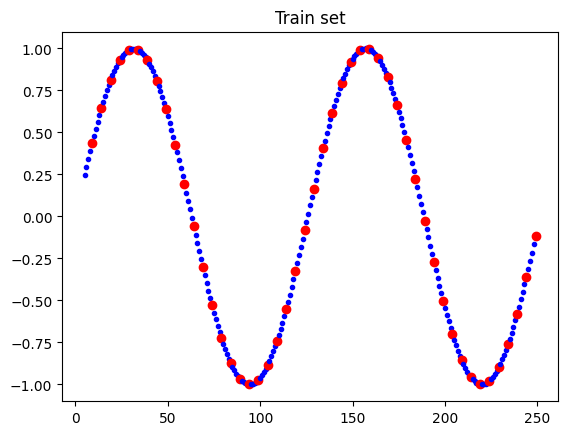

In [5]:
#Training set
x_train = np.zeros((int(data_points/4), cells))
y_train = np.zeros((int(data_points/4)))
for i in range(3, int(data_points/4)):
    x_train[i-3] = [y_sin[int(i-3)], y_sin[int(i-2)], y_sin[int(i-1)], y_sin[int(i)]]
    y_train[i-3] = y_sin[i+1]

#Sample for visualization
for i in range(1,int(data_points/20)):
    i = i * 5
    plt.plot(range(i,4+i), x_train[i], '.', color='blue')
    plt.plot(i+4, y_train[i],'o',color='red')
plt.title('Train set')

#### Validation

Text(0.5, 1.0, 'Validation set')

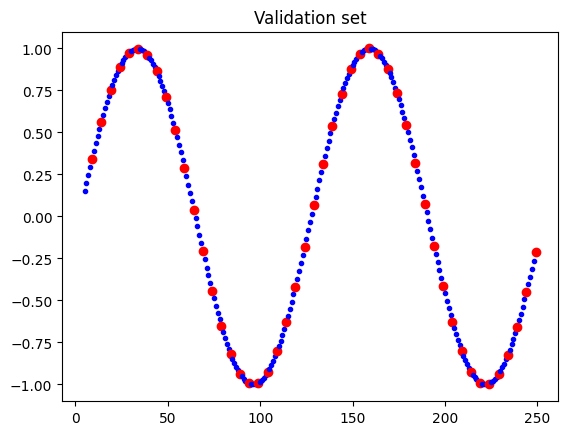

In [6]:
#Validation set
x_vali = np.zeros((int(data_points/4), cells))
y_vali = np.zeros((int(data_points/4))) 
offset = 3*int(data_points/8)
for i in range(3, int(data_points/4)):
    x_vali[i-3] = [y_sin[int(i-3 + offset)], y_sin[int(i-2 + offset)], y_sin[int(i-1 + offset)], y_sin[int(i + offset)]]
    y_vali[i-3] = y_sin[i + 1 + offset]

#Sample for visualization
for i in range(1,int(data_points/20)):
    i = i * 5
    plt.plot(range(i,4+i), x_vali[i], '.', color='blue')
    plt.plot(i+4, y_vali[i],'o',color='red')
plt.title('Validation set')

In [7]:
def prev(val):
    _, y = sinRNN.forward(x_train[val])
    print(f'Training x: {x_train[val]}\ty: {y_train[val]}\tˆy: {y[-1]}\n')
    # return y[-1]


### Training

#### Losses

In [8]:
def get_loss(rnn:RNN, X, Y):
    loss = 0
    for i in range(len(Y)):
        _ , y = rnn.forward(X[i])
        y_pred = y[-1]
        loss += (Y[i] - y_pred) **2
    return loss/(2*len(Y))

train_loss = get_loss(sinRNN, x_train, y_train)
print(f"Train loss: {train_loss}")

vali_loss = get_loss(sinRNN, x_vali, y_vali)
print(f"Validation loss: {vali_loss}")

Train loss: 260.99364730759453
Validation loss: 261.0355373880967


#### BPTT

Final train loss: 0.005210836495980754
Final validation loss: 0.005419061353456168


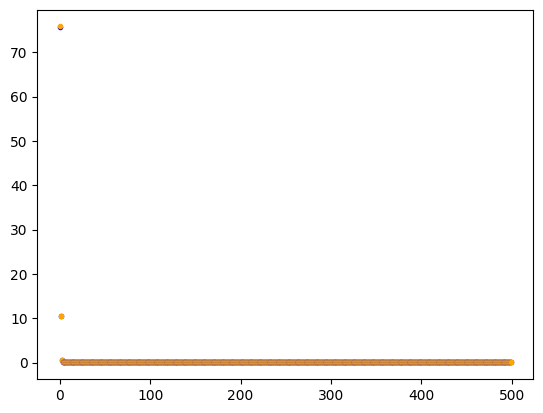

In [9]:
epochs = 500
learning_rate = 0.00005

for epoch in range(epochs):
        for data in range(len(y_train)):
                dWhh, dWih, dWho = sinRNN.backward(x_train[data], y_train[data])
                #print(dWhh, dWih, dWho)
                # update
                sinRNN.Wih -= learning_rate * dWih.T
                sinRNN.Who -= learning_rate * dWho.T
                sinRNN.Whh -= learning_rate * dWhh.T

        # if vali_loss < get_loss(sinRNN, x_vali, y_vali):
        #         break
        train_loss = get_loss(sinRNN, x_train, y_train)
        vali_loss = get_loss(sinRNN, x_vali, y_vali)

        plt.plot(epoch, train_loss, '.', color='blue')
        plt.plot(epoch, vali_loss, '.', color='orange')
print(f'Final train loss: {train_loss}')
print(f'Final validation loss: {vali_loss}')

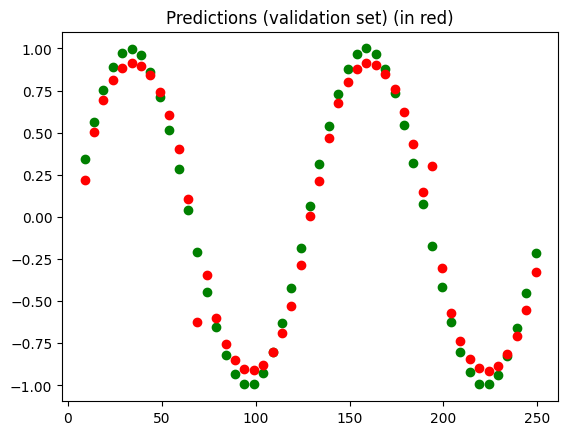

Text(0.5, 1.0, 'Predictions (train set) (in red)')

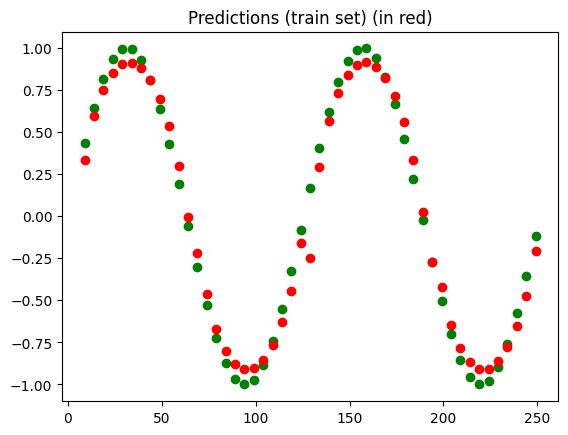

In [10]:
#Visualizing predictions
for i in range(1,int(data_points/20)):
    i = i * 5
    plt.plot(i+4, y_vali[i],'o',color='green')
    _, y = sinRNN.forward(x_vali[i])
    plt.plot(i+4, y[-1],'o',color='red')
plt.title('Predictions (validation set) (in red)')

#Visualizing predictions
plt.show()
for i in range(1,int(data_points/20)):
    i = i * 5
    plt.plot(i+4, y_train[i],'o',color='green')
    _, y = sinRNN.forward(x_train[i])
    plt.plot(i+4, y[-1],'o',color='red')
plt.title('Predictions (train set) (in red)')

```
print(pato)
    __
___( o)>
\ <_. )
 `---' 
```
